# Stage 6: Grad-CAM Visualisation and Gradio Demo Setup

# Class labels for Fashion MNIST (index to class name)

In [1]:
# Class labels for Fashion MNIST (index to class name)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# importing libraries and loading best fine tuned model 

In [2]:
# Step 1: Import required libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist

# Load Fashion MNIST dataset (only test set for now)
(_, _), (X_test, y_test) = fashion_mnist.load_data()

# Preprocess the test data
# Normalize pixel values to 0-1 range and add channel dimension
X_test = X_test.astype("float32") / 255.0
X_test = np.expand_dims(X_test, axis=-1)  # Shape: (10000, 28, 28, 1)

# : Load the tuned CNN model from Stage 3
model_path = "../models/stage3_fashion_cnn_tuned.h5"
model = load_model(model_path)
print("[INFO] Loaded model from:", model_path)

# : Define class names for Fashion MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

2025-04-17 15:11:48.124693: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 15:11:48.124819: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 15:11:48.124863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 15:11:49.525906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[INFO] Loaded model from: ../models/stage3_fashion_cnn_tuned.h5


# Grad-CAM Utility Function

In [3]:
def generate_gradcam_heatmap(model, image, last_conv_layer_name="conv2d_2", pred_index=None):
    """
    Generate Grad-CAM heatmap for a given image and CNN model.
    Includes safe normalization and debug prints.
    """

    # Expand dims to simulate batch of size 1
    img_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0))

    # Map input to activations and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradient of predicted class w.r.t conv layer output
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weighted sum of channels
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # DEBUG: Print heatmap range before normalization
    print("[DEBUG] Raw heatmap min:", np.min(heatmap))
    print("[DEBUG] Raw heatmap max:", np.max(heatmap))

    # Safe normalization
    if tf.math.reduce_max(heatmap) == 0:
        print("[WARNING] Heatmap has no activation. Returning zeros.")
        return np.zeros_like(heatmap)
    else:
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

# Visualise Grad-CAM on a batch of 5 random test images

[DEBUG] Raw heatmap min: -4.900129e-05
[DEBUG] Raw heatmap max: 0.00016397191


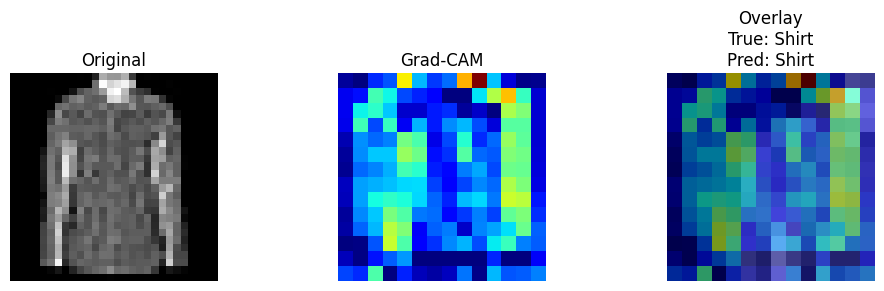

[DEBUG] Raw heatmap min: -0.0006914708
[DEBUG] Raw heatmap max: 8.4365245e-05


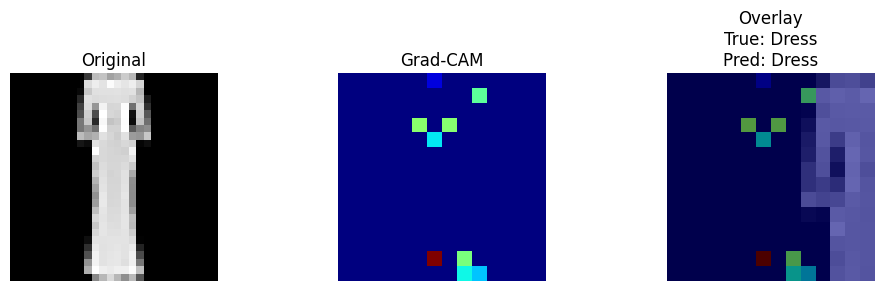

[DEBUG] Raw heatmap min: -0.0011423362
[DEBUG] Raw heatmap max: 0.0019275646


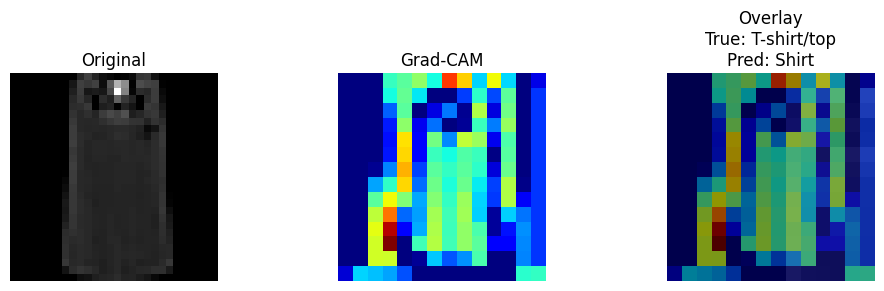

[DEBUG] Raw heatmap min: -0.0034841443
[DEBUG] Raw heatmap max: 0.021870337


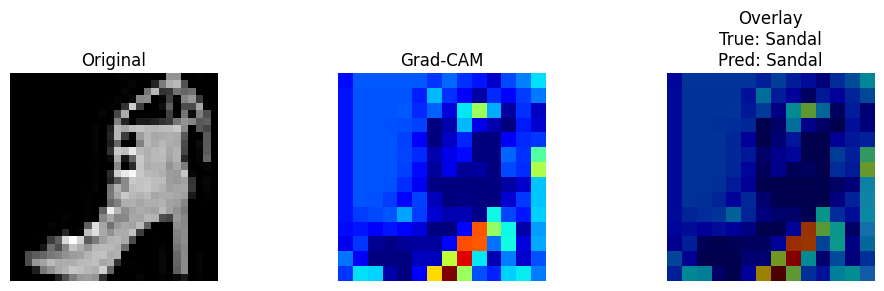

[DEBUG] Raw heatmap min: -2.8548195e-05
[DEBUG] Raw heatmap max: 4.272612e-05


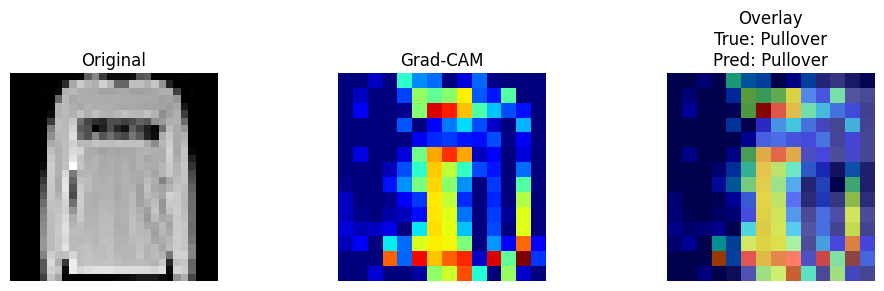

In [9]:
import os
# Create output directory if it doesn't exist
os.makedirs("gradcam_outputs", exist_ok=True)

# Number of Grad-CAM visualisations to generate
num_images = 5

# Select 5 random indices from the test set
np.random.seed(42)
random_indices = np.random.choice(len(X_test), num_images, replace=False)

# Loop through each selected image
for idx_num, idx in enumerate(random_indices):
    # Extract test image and its true class name
    image = X_test[idx]
    true_label = class_names[y_test[idx]]

    # Predict class for this image
    prediction = model.predict(image[np.newaxis, ...], verbose=0)
    predicted_class = class_names[np.argmax(prediction)]

    # Generate Grad-CAM heatmap from the selected layer
    heatmap = generate_gradcam_heatmap(model, image, last_conv_layer_name="conv2d_1")

    # Create a figure with 3 subplots: original, heatmap, overlay
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    # Plot original grayscale image
    axs[0].imshow(image.squeeze(), cmap="gray")
    axs[0].set_title("Original")
    axs[0].axis("off")

    # Plot Grad-CAM heatmap
    axs[1].imshow(heatmap, cmap="jet")
    axs[1].set_title("Grad-CAM")
    axs[1].axis("off")

    # Overlay Grad-CAM on original image
    axs[2].imshow(image.squeeze(), cmap="gray")
    axs[2].imshow(heatmap, cmap="jet", alpha=0.6)
    axs[2].set_title(f"Overlay\nTrue: {true_label}\nPred: {predicted_class}")
    axs[2].axis("off")

    # Sanitize filenames (remove or replace slashes and spaces)
    safe_true_label = true_label.replace("/", "_").replace(" ", "_")
    safe_pred_class = predicted_class.replace("/", "_").replace(" ", "_")

    # Save figure
    output_filename = f"gradcam_outputs/gradcam_{idx_num}_{safe_true_label}_pred_{safe_pred_class}.png"
    plt.savefig(output_filename, bbox_inches='tight')
    
    # Display it in notebook
    plt.tight_layout()
    plt.show()